<a href="https://colab.research.google.com/github/IRPARKS/NMML/blob/main/NMMLHW14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative Adversarial Networks (GANs)
======
This code implements a Deep Convolutional GAN (DCGAN), a GAN with only convolutional layers in the encoder and decoder.

Based on [[this notebook]](https://github.com/smartgeometry-ucl/dl4g/blob/master/gan.ipynb).

In [1]:
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils

import matplotlib.pyplot as plt

Parameter Settings
-------------------


In [2]:
latent_dims = 10
num_epochs = 20
batch_size = 128
learning_rate = 2e-4
use_gpu = False

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. The images are normalized and centerd around 0, which gives a slight performance boost during training. We create both a training set and a test set.

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(data_utils.Subset(train_dataset, range(5000)), batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(data_utils.Subset(test_dataset, range(500)), batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 19364776.90it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 580708.02it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 5771500.89it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 8516105.84it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



torch.Size([1, 28, 28])


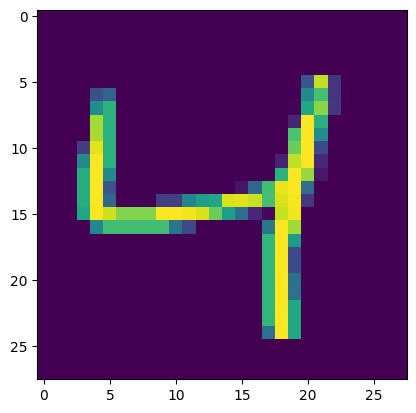

In [4]:
plt.imshow(train_dataset[2][0][0])
print(train_dataset[2][0].shape)

GAN Definition
-----------------------
We use a convolutional generator and discriminator, which generally gives better performance than fully connected versions that have the same number of parameters.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [5]:
class Generator(nn.Module):
    def __init__(self, d=16):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels = 100, out_channels = d, kernel_size = 4)
        self.deconv1_bn = nn.BatchNorm2d(d)
        self.deconv2 = nn.ConvTranspose2d(in_channels = d, out_channels = 1, kernel_size = 4, stride = 4)

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = torch.tanh(self.deconv2(x, output_size = (input.size()[0], 1, 28, 28)))

        return x

class Discriminator(nn.Module):
    def __init__(self, d=16):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = d, kernel_size = 4, stride = 2, padding = 1)
        self.conv1_bn = nn.BatchNorm2d(d)
        self.conv2 = nn.Conv2d(in_channels = d, out_channels = 1, kernel_size = 4, stride = 1, padding = 0)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(121, 1)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = self.flatten(self.conv2(x))
        x = torch.sigmoid(self.linear(x))

        return x

generator = Generator()
discriminator = Discriminator()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 25905 and discriminator: 683


Train GAN
--------


In [11]:
# GAN training can be unstable. In this case, the strong momentum
# for the gradient prevents convergence. One possible explanation is that the
# strong momentum does not allow the two players in the adversarial game to react
# to each other quickly enough. Decreasing beta1 (the exponential decay for the
# gradient moving average in [0,1], lower is faster decay) from the default 0.9
# to 0.5 allows for quicker reactions.

# Adjusting beta1 for the Adam optimizers
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')

# Training loop
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0

    # Iterate over batches in the dataloader
    for image_batch, _ in train_dataloader:

        # Get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # Generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 4, 4, device=device)
        fake_image_batch = generator(latent)

        # Train discriminator to correctly classify real and fake
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))

        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()

        # Train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)

        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        # Track losses
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

    # Calculate average losses for the epoch
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches

    # Print epoch statistics
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, num_epochs, gen_loss_avg[-1], disc_loss_avg[-1]))


Training ...
Epoch [1 / 20] average loss generator vs. discrim.: 4.551926 vs. 0.012924
Epoch [2 / 20] average loss generator vs. discrim.: 4.829787 vs. 0.010226
Epoch [3 / 20] average loss generator vs. discrim.: 5.023342 vs. 0.008574
Epoch [4 / 20] average loss generator vs. discrim.: 5.185693 vs. 0.007641
Epoch [5 / 20] average loss generator vs. discrim.: 5.267538 vs. 0.007536
Epoch [6 / 20] average loss generator vs. discrim.: 5.370863 vs. 0.007318
Epoch [7 / 20] average loss generator vs. discrim.: 5.415937 vs. 0.006668
Epoch [8 / 20] average loss generator vs. discrim.: 5.497346 vs. 0.006742
Epoch [9 / 20] average loss generator vs. discrim.: 5.482319 vs. 0.006706
Epoch [10 / 20] average loss generator vs. discrim.: 5.550913 vs. 0.006884
Epoch [11 / 20] average loss generator vs. discrim.: 5.596053 vs. 0.006377
Epoch [12 / 20] average loss generator vs. discrim.: 5.690357 vs. 0.006440
Epoch [13 / 20] average loss generator vs. discrim.: 5.636901 vs. 0.006887
Epoch [14 / 20] avera

Plot Training Curves
--------------------

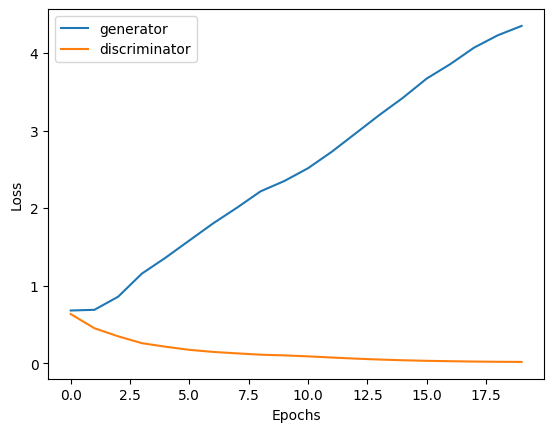

In [7]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Sample Latent Vector from Prior (GAN as Generator)
-------------------------------------------------

GANs usually generate higher-quality results than VAEs or plain Autoencoders, since the distribution of generated digits is more focused on the modes of the real data distribution (see tutorial slides). However, they are harder to train and don't have an encoder, which means the inference of a latent code from a given image is not possible.

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

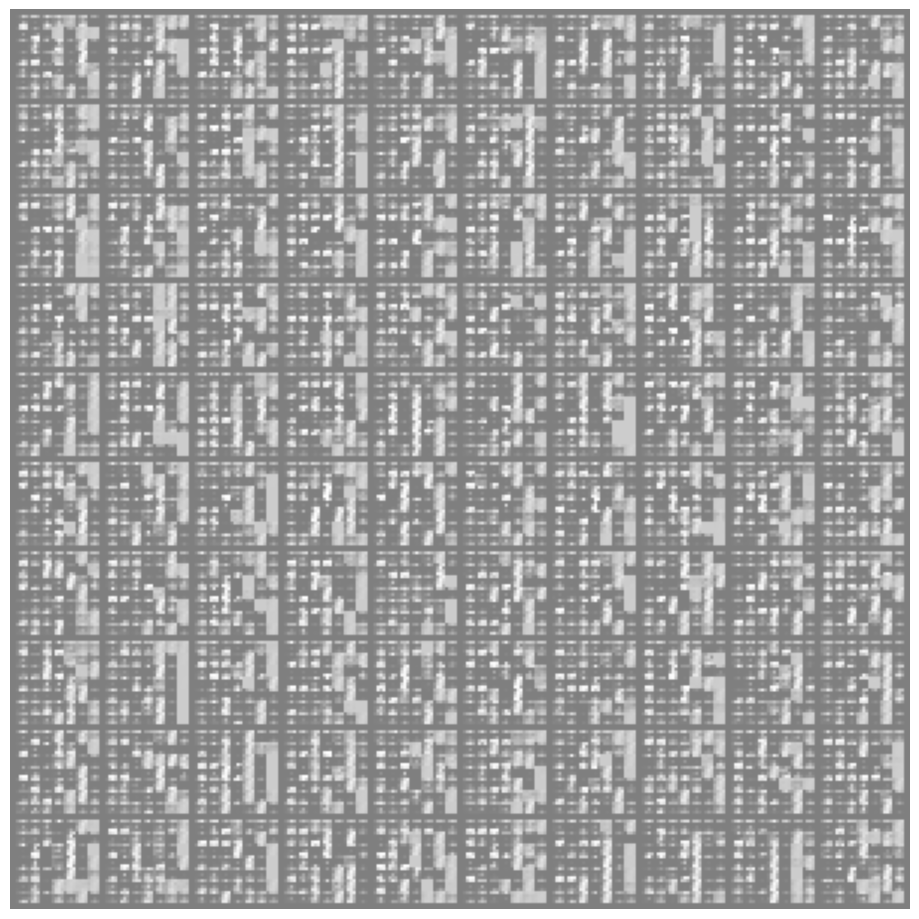

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils

# Turn off interactive mode
plt.ioff()

generator.eval()

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axis
    plt.xticks([])   # Hide ticks
    plt.yticks([])

# Desired output size
desired_output_size = (28, 28)

# Adjust the size of the latent vectors to match the input size expected by the generator
latent_vectors = torch.randn(100, 100, 4, 4, device=device)  # Adjust size if needed

# Generate fake images
with torch.no_grad():
    fake_image_batch = generator(latent_vectors)

# Resize generated images to match the desired output size
fake_image_batch_resized = torchvision.transforms.functional.resize(fake_image_batch, desired_output_size)

# Plot resized images in a grid
show_image(torchvision.utils.make_grid(fake_image_batch_resized.data[:100], nrow=10, padding=2, normalize=True))

# Adjust spacing between subplots
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

# Show the plot
plt.show()



Interpolate in Latent Space
----------------------------

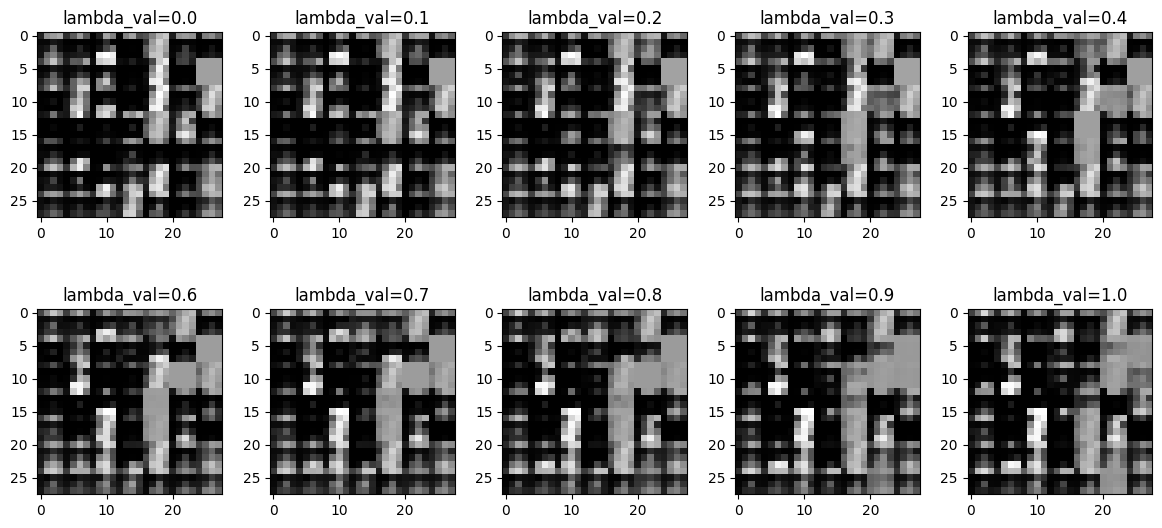

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils

# Turn on interactive mode
plt.ion()

def interpolation(lambda1, model, latent_1, latent_2):
    """Interpolates between two latent vectors and generates interpolated images.

    Args:
        lambda1 (float): Interpolation coefficient.
        model: Generator model.
        latent_1 (torch.Tensor): Latent vector 1.
        latent_2 (torch.Tensor): Latent vector 2.

    Returns:
        torch.Tensor: Interpolated image.
    """
    with torch.no_grad():
        # Interpolation of the two latent vectors
        inter_latent = lambda1 * latent_1 + (1 - lambda1) * latent_2

        # Reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# Sample two latent vectors from the standard normal distribution
latent_1 = torch.randn(1, 100, 4, 4, device=device)
latent_2 = torch.randn(1, 100, 4, 4, device=device)

# Interpolation lambdas
lambda_range = np.linspace(0, 1, 10)

# Create subplots for displaying interpolated images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.001)
axs = axs.ravel()

for ind, l in enumerate(lambda_range):
    # Generate interpolated image
    inter_image = interpolation(float(l), generator, latent_1, latent_2)

    # Convert interpolated image to numpy array
    inter_image_np = to_img(inter_image).numpy()

    # Display interpolated image
    axs[ind].imshow(inter_image_np[0, 0, :, :], cmap='gray')
    axs[ind].set_title('lambda_val=' + str(round(l, 1)))

# Show the plot
plt.show()
